**Problem Set #1**

Computational Astrodynamics (ΥΦΥ204)

Implemented by: **Anastasios-Faidon Retselis (AEM: 4394)**

# Exercise 1.1

Let us first study the Molniya orbit as defined by the problem statement. We are given the inclination ($i=63.4^{\circ}$) and the eccentricity ($e=0.64$). Using the pre-defined period of the orbit ($T=12\: hours=43200\:seconds$), we can derive the semi-major axis of the orbit using Kepler's third law:

$$ 
\begin{split}
T^{2} &=\frac{4 \pi^{2}}{\mu} a^{3} \\
\Rightarrow a^{3} &=\frac{T^{2}\mu}{4\pi^{2}} \\ 
\Rightarrow a^{3} &=\frac{T^{2}G(M_{earth}+M_{satellite})}{4\pi^{2}} \\
\Rightarrow a^{3} &\approx \frac{T^{2}G(M_{earth})}{4\pi^{2}}
\end{split}
$$

and using the values $G=6.6743\times10^{-11} \frac{kg m^{3}}{s^{2}kg^{2}}$ and $M_{earth}=5.977\times10^{24}kg$ we get:

$$
\begin{split}
a &= 26617396\:m \\
\Rightarrow a &= 26617.396\:km
\end{split}
$$

Considering that for $t=\tau=0$ the line of the nodes coincides with OY axis of the ICRF reference frame and that the apogee of the orbit points towards the first point of aries (point $\gamma$), we can determine that $\Omega=270^{\circ}$ and $\omega=270^{\circ}$. If we also take into account that for $t=\tau=0$ the satellite finds itself at the perigee of the orbit, we can also determine that the mean anomaly is $M_{initial}=0$. We also note that the mean anomaly is given by the following equation:

$$
\begin{split}
M &= n(t-\tau) \\
\Rightarrow Μ &= \frac{360^{\circ}}{T}(t-\tau) 
\end{split}
$$

The orbital elements of the Molniya orbit for $t=\tau=0$ can be summarized below:

|         Orbital Element         |     Value     |
|:-------------------------------:|:-------------:|
|         Semi-major axis         |  26617396 m   |
|           Eccentricity          |     $0.64$    |
|           Inclination           |     $63.4$    |
| Longitude of the ascending node | $270^{\circ}$ |
|      Argument of pericenter     | $270^{\circ}$ |
|           Mean anomaly          |       0       |

In [83]:
import numpy as np

def orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # a [m]
    # e []
    # i [deg]
    # Omega [deg]
    # omega [deg]
    # M [deg]
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # r_vector, y_vector
    
    # Compute E using Newton-Raphson
    # Define initial value for E_0
    if M > -np.pi and M < 0:
        E_0 = M - e
    elif M > np.pi:
        E_0 = M + e
    else:
        E_0 = 0.1
    # Convert M to radians
    M = np.radians(M)
    # Define f and f dot
    f = lambda E : M-E+np.sin(E)
    fdot = lambda E : -1+np.cos(E)
    # Stopping criteria 
    N = 10  # Number of significant digits to be computed
    max_repetitions = 100
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev)/fdot(E_prev))
        ea = np.fabs((E_next-E_prev)*100/E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            #print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next  
    # Compute x, xdot, y, ydot on the orbital plane
    x = a * (np.cos(E) - e)
    y = a * np.sqrt(1 - pow(e, 2)) * np.sin(E)
    r = np.sqrt(pow(x, 2) + pow(y, 2))
    n = np.sqrt(mu/pow(a, 3)) # Mean motion
    x_dot = -(n * pow(a, 2) / r) * np.sin(E)
    y_dot = (n * pow(a, 2) / r) * np.sqrt(1 - pow(e, 2)) * np.cos(E)
    # Rotation Matrices definition
    Omega = np.radians(Omega)
    omega = np.radians(omega)
    i = np.radians(i)
    P1 = np.array([[np.cos(omega),-np.sin(omega),0],
                   [np.sin(omega),np.cos(omega),0],
                   [0,0,1]])
    P2 = np.array([[1,0,0],
                   [0,np.cos(i),np.sin(i)],
                   [0,np.sin(i),np.cos(i)]])
    P3 = np.array([[np.cos(Omega),-np.sin(Omega),0],
                   [np.sin(Omega),np.cos(Omega),0],
                   [0,0,1]])
    # Compute cartesian coordinates
    x_y_vector = np.array([x,y,0])
    x_y_dot_vector = np.array([x_dot,y_dot,0])
    r_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1),x_y_vector)
    v_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1),x_y_dot_vector)
    return(r_vector, v_vector)


# Orbit definition

a = 26617396  # Semi-major axis
e = 0.64  # Eccentricity
i = 63.4  # Inclination
Omega = 270  # Longitude of the Ascending Note
omega = 270  # Argument of pericenter
M = 0  # Mean Anomaly

# System properties 

G = 6.6743*pow(10,-11)
M_earth = 5.977*pow(10,24)
mu = G*M_earth

# Orbital elements -> Cartesian
r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu)


B)

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def cartesian_to_orbital_elements(r_vector, v_vector, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # r_vector, y_vector
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # a [m] (Semi-major axis)
    # e [] (Eccentricity)
    # i [deg] (Inclination)
    # Omega [deg] (Longitude of the ascending node)
    # omega [deg] (Argument of pericenter)
    # ni [deg] (True anomaly)
    # M [deg] (Mean anomaly)
    
    # Compute magnitude and angular momentum
    r = np.sqrt(pow(r_vector[0], 2) + pow(r_vector[1], 2) + pow(r_vector[2], 2))
    v = np.sqrt(pow(v_vector[0], 2) + pow(v_vector[1], 2) + pow(v_vector[2], 2))
    h_vector = np.cross(r_vector, v_vector)
    h = np.sqrt(pow(h_vector[0], 2) + pow(h_vector[1], 2) + pow(h_vector[2], 2))
    # Compute a, e and i
    a = mu/((2*mu/r) - pow(v, 2))
    e = np.sqrt(1-(pow(h, 2)/(mu*a)))
    i = np.arccos(h_vector[2]/h)
    # Compute Omega (Longitude of the Ascending Node)
    if h_vector[2] > 0:
        sin_Omega = h_vector[0] / (h * np.sin(i))
        cos_Omega = - h_vector[1] / (h * np.sin(i))
    else:
        sin_Omega = - h_vector[0] / (h * np.sin(i))
        cos_Omega = h_vector[1] / (h * np.sin(i))
    if sin_Omega >= 0:
        Omega = np.arccos(cos_Omega)
    else:
        Omega = 2*np.pi - np.arccos(cos_Omega)
    # Compute E
    cos_E = (a-r)/(a*e)
    sin_E = np.dot(r_vector, v_vector) / (e * np.sqrt(mu*a))
    # Compute true anomaly
    cos_ni = (cos_E - e) / (1 - (e * cos_E))
    sin_ni = (np.sqrt(1 - pow(e, 2)) * sin_E) / (1 - (e * cos_E))
    if sin_ni >= 0:
        ni = np.arccos(cos_ni)
    else:
        ni = 2*np.pi - np.arccos(cos_ni)
    # Compute mean anomaly
    if sin_E >= 0:
        E = np.arccos(cos_E)
    else:
        E = 2*np.pi - np.arccos(cos_E)
    M = E - e*sin_E
    # Compute omega (argument of pericenter)
    sin_omega_plus_ni = r_vector[2] / (r * np.sin(i))
    cos_omega_plus_ni = ((r_vector[0] * cos_Omega) + (r_vector[1] * sin_Omega))/r
    if  sin_omega_plus_ni >= 0:
        omega = np.arccos(cos_omega_plus_ni) - ni
    else:
        omega = 2*np.pi - np.arccos(cos_omega_plus_ni) - ni
    
    # Convert to degrees
    i = np.degrees(i)
    Omega = np.degrees(Omega)
    ni = np.degrees(ni)
    M = np.degrees(M)
    omega = np.degrees(omega)
    return(a, e, i, Omega, omega, ni, M)
    
a, e, i, Omega, omega, ni, M = cartesian_to_orbital_elements(r_vector, v_vector, mu)
print(a, e, i, Omega, omega, ni, M)

26617396.000000034 0.6400000000000005 63.4 270.0 -90.0000000000002 348.34342206656567 358.02327139396976


C)



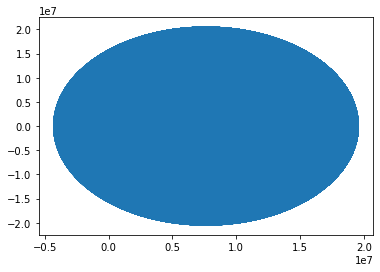

In [87]:
step_size = 0.01

# Orbit definition

a = 26617396  # Semi-major axis
e = 0.64  # Eccentricity
i = 63.4  # Inclination
Omega = 270  # Longitude of the Ascending Note
omega = 270  # Argument of pericenter

# System properties 

G = 6.6743*pow(10,-11)
M_earth = 5.977*pow(10,24)
mu = G*M_earth

t_max = 1 * 43200
x_values = np.zeros(t_max)
y_values = np.zeros(t_max)
z_values = np.zeros(t_max)

for t in range(0, t_max):
    M = (360/43200)*t  # Mean Anomaly
    r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu)
    x_values[t] = r_vector[0]
    y_values[t] = r_vector[1]
    z_values[t] = r_vector[2]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x_values, y_values, z_values)
plt.show()

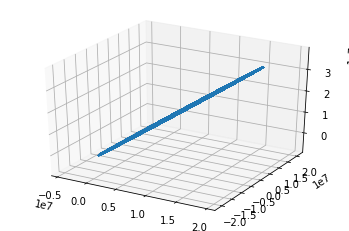

In [89]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x_values, y_values, z_values)
plt.show()